# Génération de gaussienne par modèle de diffusion

<h2>Importation</h2>

In [7]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import normal
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

<h2>Affichage des points</h2>

<p>Fonction qui prend en argument des points sous forme de tableau numpy ou bien de tensor et qui les affiche</p>

In [8]:
def show_points(X):
    nb_points,dim = X.shape
    plt.figure(figsize=(dim*(dim-1) * 10,5))
    nb_plot=0
    for d1 in range(dim):
        for d2 in range(d1+1,dim):
            xs,ys = [],[]
            nb_plot+=1
            for i in range(nb_points):
                xs.append(X[i][d1])
                ys.append(X[i][d2])
            plt.subplot(1,dim**2,nb_plot)
            plt.title(f"({d1},{d2})")
            plt.scatter(xs,ys, marker='+')
    plt.show()
    return

<h2>Modèles</h2>

<p>On utilise différent modèles : 
    <ul>
        <li>Le modèle Net. C'était notre modèle initiale qui contient seulement quelques couches linéaires</li>
        <li>DiffusionBlock : Contient le block du milieu pour le modèle DiffusionModel</li>
        <li>DiffusionModel : Contient un modèle assez similaire à celui utilisé dans le notebook</li>
        <li>Diff : Modèle qui va gérer toute la diffusion</li>
</p>

In [79]:
class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)
        
    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x
        
class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()
        
        self.inblock = nn.Linear(nfeatures+1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        t = t.reshape(-1, 1)
        val = torch.hstack([x, t])  # Add t to inputs
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val

class Diff(nn.Module):
    def __init__(self,network, num_timesteps,beta_start = 1e-4, beta_end = 0.1, device = "cpu"):
        super(Diff,self).__init__()
        self.num_timesteps = num_timesteps
        self.network = network
        self.device = device
        
        """Notre version originale pour choisir les beta
        self.betas = torch.linspace(beta_start,beta_end,num_timesteps,dtype=torch.float32).to(device)
        #self.betas = self.betas.to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas,axis=0)
        self.sqrt_alphas_cumprod = self.alphas_cumprod**0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5
        """

        """La version du notebook qui se base sur https://arxiv.org/pdf/2102.09672.pdf"""
        s = 0.008
        timesteps = torch.tensor(range(0, num_timesteps), dtype=torch.float32)
        schedule = torch.cos((timesteps / num_timesteps + s) / (1 + s) * torch.pi / 2)**2
        self.alphas_cumprod = schedule / schedule[0]
        self.sqrt_alphas_cumprod = self.alphas_cumprod**0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod)**0.5
        self.betas = 1 - self.alphas_cumprod / torch.concatenate([self.alphas_cumprod[0:1], self.alphas_cumprod[0:-1]])
        self.alphas = 1 - self.betas

    def plot_alphacumprods(self):
        #Fonction qui permet d'afficher les beta et de vérifier que la courbe a à peu près la forme voulue
        plt.plot(torch.arange(1, num_timesteps + 1), self.alphas_cumprod)
        plt.show()
        
    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps].reshape(-1,1).to(device) # bs
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps].reshape(-1,1).to(device) # bs
        return x_start * s1 + x_noise * s2
        
    def reverse(self,x,t):
        return self.network(x,t)
        
    def step(self, model_output, timestep, sample):
        # model_output = epsilon_theta, timestep = t, sample = x_t
        # but: avoir x_{t-1}
        t = timestep
        coef_eps_t= ((1-self.alphas[t])/self.sqrt_one_minus_alphas_cumprod[t]).reshape(-1,1).to(device)
        coef_first_t = (1/self.alphas[t] ** 0.5).reshape(-1,1).to(device)
        pred_prev_sample = (coef_first_t*(sample-coef_eps_t*model_output)).to(device)
        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(self.device)
            variance = ((self.betas[t] ** 0.5) * noise).to(device)

        pred_prev_sample = pred_prev_sample + variance
        return pred_prev_sample.to(device)

<h2>Training loop</h2>
<p>La training loop est simple, on optimise pour apprendre le bruit aouté à chaque étape</p>

In [117]:
def training_loop(model,dataloader,optim,num_ep,num_timesteps,device=device):
    global_step = 0
    losses = []
    
    for epoch in range(num_ep):
        if epoch != 0 and epoch % 10 == 0:
            print(f"New epoch ({epoch}) last losses: {losses[-1]}, average lost on the last ten epoch : {sum(losses[-10:]) / 10}")
        model.train()
        l = 0
        
        for step, batch in enumerate(dataloader):
            batch = batch.to(device) # les x0 avec lesquels je vais me train.
            noise = torch.randn(batch.shape).to(device) # un epsilon par x0 pour les flouter
            timesteps = torch.randint(num_timesteps,(batch.shape[0],)).long().to(device)
            noisy = model.add_noise(batch, noise, timesteps) # xt
            noise_pred = model.reverse(noisy, timesteps) # on essaye de prédire le epsilon à partir des images floutées.
            loss = F.mse_loss(noise_pred, noise)
            optim.zero_grad()
            loss.backward()
            optim.step()
            l+=loss.detach().item()
            global_step += 1
        losses.append(l/len(dataloader))
    plt.plot(torch.arange(num_ep), losses)
    plt.show()

<h2>Dataset</h2>
<p>On créer une classe MultivariateNormalDataset qui permet de générer des points selon différentes distributions gaussiennes. A terme, le but serait d'avoir différentes classe permettant d'avoir différents types de distributions afin de vérifier que ça apprend bien à chaque fois</p>

In [58]:
class MultivariateNormalDataset(Dataset):
    def __init__(self, mean, std, num_samples):
        mean = mean.expand(num_samples, -1)
        std = std.expand(num_samples, -1)
        self.data = torch.normal(mean=mean, std=std)
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

<h2>Mise en pratique</h2>
<p>On va entraîner notre modèle sur des distributions de difficultés variables. A noter qu'il semble qu'à chaque fois il est nécéssaire de redéfinir toutes les constantes beta_start, beta_end, nombre de sample et nombre d'étapes de bruitage parce que c'est directement lié au dataset qu'on essaie de générer. En effet, il faut faire d'avoir le bon nombre de num_steps de sorte que ça suffise pour transformer notre distribution initiale en quelques chose de gaussien centré en 0 et de variance 1, mais pas plus car autrement ça fausse les résultats à la fin. Pour cela, on commence par créer une fonction plot_full_noise qui permet d'appliquer tout le bruit sur notre dataset de départ et de voir si la pahse de bruitage est suffisament longue</p>

In [59]:
def get_full_noise(dataset, model):
    noise = torch.randn(dataset.data.shape).to(device) # un epsilon par x0 pour les flouter
    timesteps = torch.full((dataset.data.shape[0],), model.num_timesteps - 1).long().to(device)
    noisy = model.add_noise(dataset.data, noise, timesteps)
    return noisy 

<h3>Gaussiennes</h3>

In [149]:
num_samples = 10000  # Number of samples
batch_size = 2048   # Batch size

#On commence avec une gaussienne centrée en (6, 6) et avec une variance de (2, 2)
dim=2
mean = 4*torch.ones((dim,))
std = 2*torch.ones((dim,))

dataset = MultivariateNormalDataset(mean,std, num_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

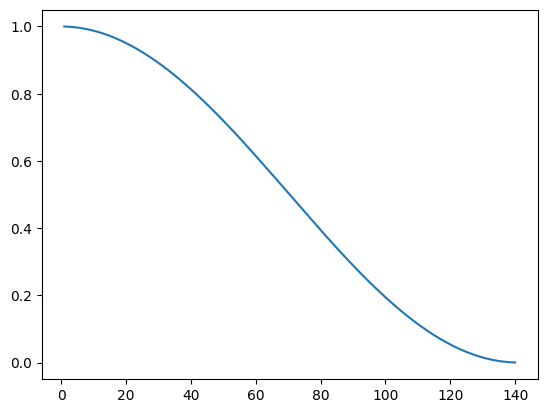

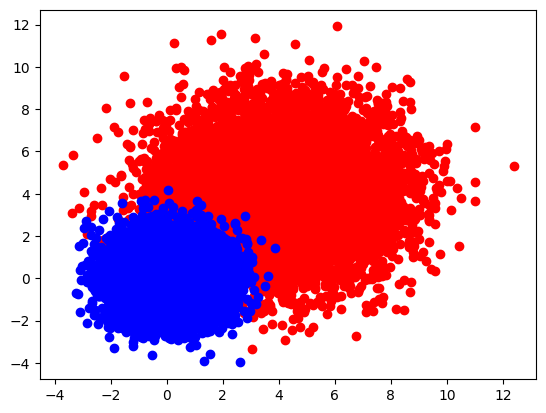

Moyenne de la distribution d'entraînement : tensor([4.0192, 4.0084])
Variance de la distribution initiale : tensor([2.0060, 1.9898])
Moyenne de la distribution bruitée : tensor([0.0466, 0.0463])
Variance de la distribution bruitée : tensor([0.9947, 0.9968])


In [150]:

lr = 1e-3
num_epochs = 1000
num_timesteps = 140

beta_start = 1e-4
beta_end = 0.05

network = DiffusionModel(dim, nblocks=2, nunits=64).to(device)
model = Diff(network,num_timesteps,device = device, beta_start=beta_start, beta_end=beta_end)
model.plot_alphacumprods()

plt.scatter(dataset.data[:, 0], dataset.data[:, 1], color='red')
noisy = get_full_noise(dataset, model)
plt.scatter(noisy[:, 0], noisy[:, 1], color='blue')
plt.show()

print(f"Moyenne de la distribution d'entraînement : {torch.mean(dataset.data, axis=0)}")
print(f"Variance de la distribution initiale : {torch.std(dataset.data, axis=0)}")
print(f"Moyenne de la distribution bruitée : {torch.mean(noisy, axis=0)}")
print(f"Variance de la distribution bruitée : {torch.std(noisy, axis=0)}")

New epoch (10) last losses: 0.8985359787940979, verage lost on the last ten epoch : 0.9803288888931274
New epoch (20) last losses: 0.8120853781700135, verage lost on the last ten epoch : 0.846441684961319
New epoch (30) last losses: 0.7804548740386963, verage lost on the last ten epoch : 0.7968337750434875
New epoch (40) last losses: 0.7585011005401612, verage lost on the last ten epoch : 0.7668964767456055
New epoch (50) last losses: 0.7473367214202881, verage lost on the last ten epoch : 0.7495276951789857
New epoch (60) last losses: 0.7393324732780456, verage lost on the last ten epoch : 0.7430061888694763
New epoch (70) last losses: 0.7308198094367981, verage lost on the last ten epoch : 0.7436093628406525
New epoch (80) last losses: 0.7474570631980896, verage lost on the last ten epoch : 0.7336185312271117
New epoch (90) last losses: 0.7282234191894531, verage lost on the last ten epoch : 0.7285575139522552
New epoch (100) last losses: 0.7395876288414002, verage lost on the last t

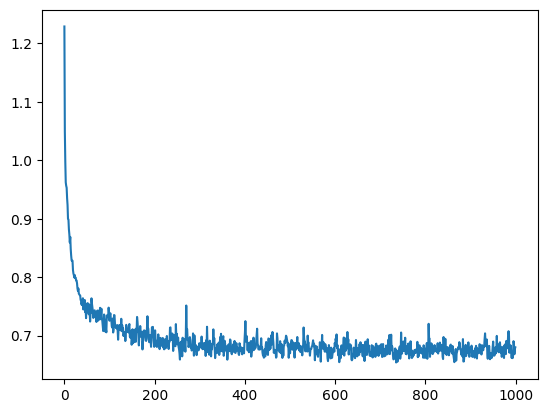

In [151]:
optimizer = torch.optim.Adam(network.parameters(), lr=lr)
training_loop(model,dataloader,optimizer,num_epochs,num_timesteps)

In [181]:
def genere_un_point(model):
    sample = torch.randn(dim).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        timesteps = list(range(model.num_timesteps))[::-1]
        #Pour une raison incompréhensible, on obtient que des nan si on fait la dernière étape
        timesteps.pop()
        for i,t in enumerate(timesteps):
            time_tensor = (torch.ones(1,) * t).long().to(device)
            residual = model.reverse(sample,time_tensor)
            sample = model.step(residual,time_tensor,sample)
            # p(xt-1 | xt), prend en entrée le epislon_theta, et le temps où on est, et la version floutée.
    return sample

In [152]:
X = torch.tensor([])
X = X.to('cpu')

for i in range(1000):
    if i % 100 ==0 and i != 0: 
        print(f"generated {i} points.")
    x = genere_un_point(model)
    x = x.to('cpu')
    X = torch.concatenate((X, x))

generated 100 points.
generated 200 points.
generated 300 points.
generated 400 points.
generated 500 points.
generated 600 points.
generated 700 points.
generated 800 points.
generated 900 points.


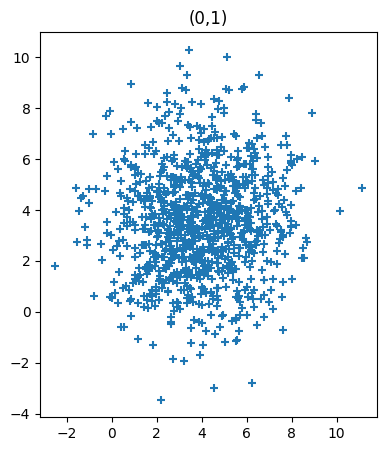

tensor([[6.2393, 2.4076],
        [4.8741, 3.7665],
        [5.2310, 3.6693],
        ...,
        [6.3884, 2.7534],
        [2.5465, 2.7666],
        [8.5699, 2.1160]])


In [153]:
show_points(X)
print(X)

In [154]:
print(torch.mean(X, axis=0))
print(torch.std(X, axis=0))

tensor([3.9173, 3.5168])
tensor([2.0219, 2.0930])


<h2>Distribution en carré</h2>
<p>Pour l'instant on garde le code au cas où mais pas sûr que ça soit vraiment utile</p>

In [19]:
class CarreDataset(Dataset):
    def __init__(self, mean, std, num_samples):
        #self.data = np.array([torch.normal(mean=mean, std=std) for _ in range(num_samples)])
        self.data = torch.rand(num_samples, 2) * 2 - 1
        self.data += mean
        self.data *= std
        self.num_saples = num_samples
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

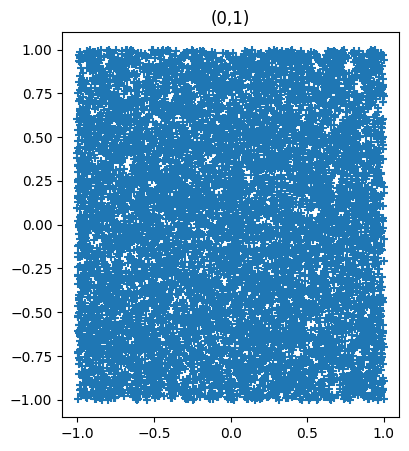

In [20]:
num_samples = 10000  # Number of samples
batch_size = 32     # Batch size
mean = 0
std = 1
dataset = CarreDataset(mean, std, num_samples)
show_points(dataset2.data)
dataloader2 = DataLoader(dataset2, batch_size=batch_size, shuffle=True)

In [21]:
lr = 1e-3
num_epochs = 100
num_timesteps = 200
network2 = Net(dim+1,dim)
network2 = network.to(device)
model2 = Diff(network2,num_timesteps,device = device)
optimizer = torch.optim.Adam(network2.parameters(), lr=lr)
training_loop(model2,dataloader2,optimizer,num_epochs,num_timesteps)

New epoch (1) last losses: 0.2564042791271933
New epoch (2) last losses: 0.20484735178776062
New epoch (3) last losses: 0.2177668165998718
New epoch (4) last losses: 0.20670821936652303
New epoch (5) last losses: 0.20641355742566503
New epoch (6) last losses: 0.21249245654660673
New epoch (7) last losses: 0.2113566357321061
New epoch (8) last losses: 0.19609140691618188
New epoch (9) last losses: 0.19603928034535992
New epoch (10) last losses: 0.19459802735918247
New epoch (11) last losses: 0.2088506602869628
New epoch (12) last losses: 0.2081410606948141
New epoch (13) last losses: 0.19912298080829766
New epoch (14) last losses: 0.19580830182558812
New epoch (15) last losses: 0.19976421057606658
New epoch (16) last losses: 0.1986248168392113
New epoch (17) last losses: 0.20047574764052137
New epoch (18) last losses: 0.19979653145653753
New epoch (19) last losses: 0.20051578045510254
New epoch (20) last losses: 0.20496712101343723
New epoch (21) last losses: 0.1910281884022795
New epoc

KeyboardInterrupt: 

In [ ]:
X = []
for i in range(500):
    X.append(genere_un_point(model2)[0])
    #if len(X) % 500 == 0 and len(X)>0:
Y = [x.cpu() for x in X]
show_points(np.array(Y))

<h2>Distribution en spirale</h2>
<p>Distribution en forme de spirale qui normalement devrait être un peu plus dure à apprendre. Petite remarque : jusqu'à maintenant on ne faisait pas le classique centralisation + normalisation avant d'apprendre parce que ça aurait un peu faussé tout l'intérêt de nos distributions précédentes, mais à partir de maintenant il faut le faire</p>

In [163]:
class SpiraleDataset(Dataset):
    def __init__(self, theta_max, a, b, num_samples):
        theta = torch.rand(num_samples) * theta_max
        radius = a + b * theta
        
        self.data = torch.stack((radius * torch.cos(theta), radius * torch.sin(theta)), dim=1)
        self.data -= torch.mean(self.data, axis=0)
        self.data /= torch.std(self.data, axis=0)
        
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

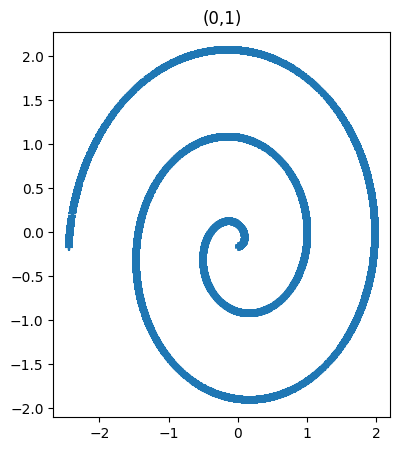

In [165]:
num_samples = 10000  # Number of samples
batch_size = 2048   # Batch size

dataset_spirale = SpiraleDataset(5 * torch.pi, 0, 5, num_samples)
show_points(dataset_spirale.data)
dataloader_spirale = DataLoader(dataset_spirale, batch_size=batch_size, shuffle=True)

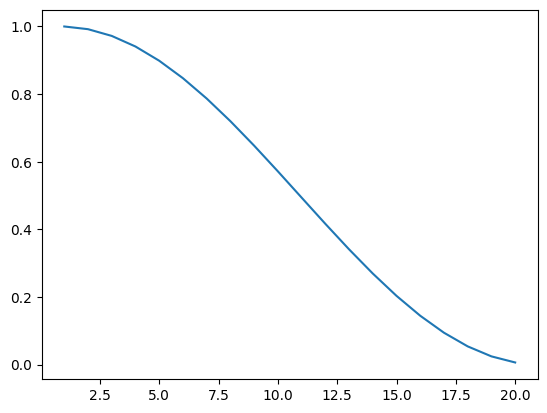

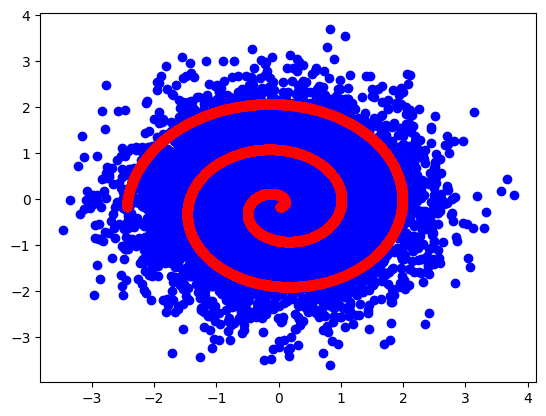

Moyenne de la distribution d'entraînement : tensor([6.8665e-09, 2.2888e-09])
Variance de la distribution initiale : tensor([1., 1.])
Moyenne de la distribution bruitée : tensor([0.0075, 0.0181])
Variance de la distribution bruitée : tensor([0.9905, 0.9989])


In [177]:
lr = 1e-3
num_epochs = 1000
num_timesteps = 20

beta_start = 1e-4
beta_end = 0.05

network_spirale = DiffusionModel(dim, nblocks=2, nunits=64).to(device)
model_spirale = Diff(network,num_timesteps,device = device, beta_start=beta_start, beta_end=beta_end)
model_spirale.plot_alphacumprods()

plt.scatter(noisy[:, 0], noisy[:, 1], color='blue')
plt.scatter(dataset_spirale.data[:, 0], dataset_spirale.data[:, 1], color='red')
noisy = get_full_noise(dataset_spirale, model_spirale)
plt.show()

print(f"Moyenne de la distribution d'entraînement : {torch.mean(dataset_spirale.data, axis=0)}")
print(f"Variance de la distribution initiale : {torch.std(dataset_spirale.data, axis=0)}")
print(f"Moyenne de la distribution bruitée : {torch.mean(noisy, axis=0)}")
print(f"Variance de la distribution bruitée : {torch.std(noisy, axis=0)}")

New epoch (10) last losses: 0.958091425895691, verage lost on the last ten epoch : 0.9596738588809967
New epoch (20) last losses: 0.9731227993965149, verage lost on the last ten epoch : 0.9608667111396789
New epoch (30) last losses: 0.9423965573310852, verage lost on the last ten epoch : 0.9565298676490783
New epoch (40) last losses: 0.9641867280006409, verage lost on the last ten epoch : 0.9611705815792083
New epoch (50) last losses: 0.9640477061271667, verage lost on the last ten epoch : 0.9557126784324647
New epoch (60) last losses: 0.9698595404624939, verage lost on the last ten epoch : 0.9602584958076477
New epoch (70) last losses: 0.9451434969902038, verage lost on the last ten epoch : 0.9616369497776031
New epoch (80) last losses: 0.9531607151031494, verage lost on the last ten epoch : 0.9577076804637908
New epoch (90) last losses: 0.9748258590698242, verage lost on the last ten epoch : 0.9665759623050689
New epoch (100) last losses: 0.9588568449020386, verage lost on the last t

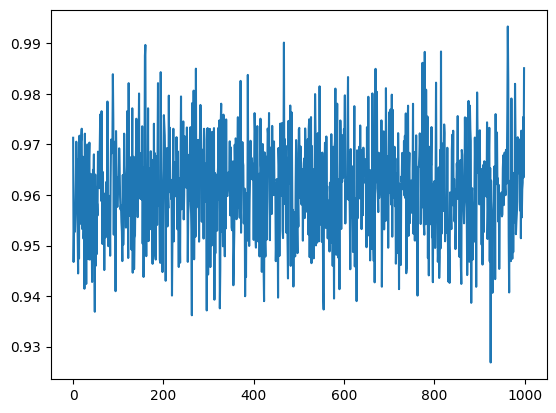

In [179]:
optimizer_spirale = torch.optim.Adam(network_spirale.parameters(), lr=lr)
training_loop(model_spirale,dataloader_spirale,optimizer_spirale,num_epochs,num_timesteps)

generated 100 points.
generated 200 points.
generated 300 points.
generated 400 points.
generated 500 points.
generated 600 points.
generated 700 points.
generated 800 points.
generated 900 points.


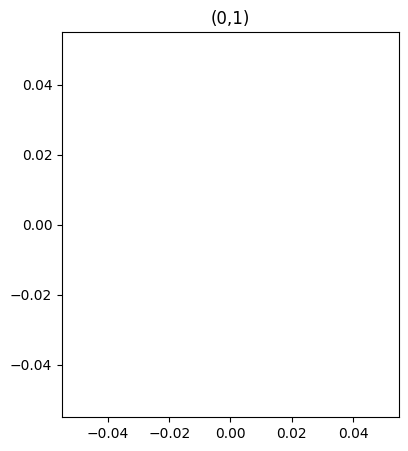

In [182]:
X = torch.tensor([])
X = X.to('cpu')

for i in range(1000):
    if i % 100 ==0 and i != 0: 
        print(f"generated {i} points.")
    x = genere_un_point(model)
    x = x.to('cpu')
    X = torch.concatenate((X, x))

show_points(X)

In [ ]:
<h2>